In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Input,Dropout,Dense
from keras.models import Model
from keras import regularizers
from keras.utils.data_utils import get_file
from sklearn.model_selection import train_test_split
from numpy.random import seed
%matplotlib inline

Using TensorFlow backend.


In [2]:
col_names=["id","dur","proto","service","state",
           "spkts","dpkts","sbytes","dbytes","rate",
           "sttl","dttl","sload","dload","sloss",
           "dloss","sinpkt","dinpkt","sjit","djit",
           "swin","stcpb","dtcpb","dwin","tcprtt",
           "synack","ackdat","smean","dmean","trans_depth",
           "response_body_len","ct_srv_src","ct_state_ttl","ct_dst_ltm","ct_src_dport_ltm",
           "ct_dst_sport_ltm","ct_dst_src_ltm","is_ftp_login","ct_ftp_cmd","ct_flw_http_mthd",
           "ct_src_ltm","ct_srv_dst","is_sm_ips_ports","attack_cat","label"
]

training_df = pd.read_csv("UNSW_NB15_training-set.csv",header=None,names=col_names)
testing_df = pd.read_csv("UNSW_NB15_testing-set.csv",header=None,names=col_names)


In [3]:
del training_df['id']
training_df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.0902,254,...,1,2,0,0,0,1,2,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.0003,254,...,1,2,0,0,0,1,2,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.0051,254,...,1,3,0,0,0,1,3,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.6608,254,...,1,3,0,0,0,2,3,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.0025,254,...,1,3,0,0,0,2,3,0,Normal,0


In [4]:
del testing_df['id']
testing_df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [5]:
print("Training set has {} rows.".format(len(training_df)))
print("Testing set has {} rows.".format(len(testing_df)))

Training set has 82332 rows.
Testing set has 175341 rows.


In [6]:
training_attacks=training_df["attack_cat"].unique()
testing_attacks=testing_df["attack_cat"].unique()
print("The training set has {} possible outcomes \n".format(len(training_attacks)) )
print(", ".join(training_attacks)+".")
print("\nThe testing set has {} possible outcomes \n".format(len(testing_attacks)))
print(", ".join(testing_attacks)+".")

The training set has 10 possible outcomes 

Normal, Reconnaissance, Backdoor, DoS, Exploits, Analysis, Fuzzers, Worms, Shellcode, Generic.

The testing set has 10 possible outcomes 

Normal, Backdoor, Analysis, Fuzzers, Shellcode, Reconnaissance, Exploits, DoS, Worms, Generic.


In [7]:
# testing_df = testing_df.fillna(0)
# testing_df['attack_cat'].unique()

In [8]:
reconnaissance_attacks=['Reconnaissance']
backdoor_attacks=['Backdoor']
dos_attacks=['DoS']
exploits_attacks=['Exploits']
analysis_attacks=['Analysis']
fuzzers_attacks=['Fuzzers']
worms_attacks=['Worms']
shellcode_attacks=['Shellcode']
generic_attacks=['Generic']

classes=["Normal","Reconnaissance","Backdoor", "DoS", "Exploits", "Analysis", "Fuzzers", "Worms", "Shellcode", "Generic"]

#Helper function to label samples to 5 classes
def label_attack (row):
    if row["attack_cat"] in reconnaissance_attacks:
        return classes[1]
    if row["attack_cat"] in backdoor_attacks:
        return classes[2]
    if row["attack_cat"] in dos_attacks:
        return classes[3]
    if row["attack_cat"] in exploits_attacks:
        return classes[4]
    if row["attack_cat"] in analysis_attacks:
        return classes[5]
    if row["attack_cat"] in fuzzers_attacks:
        return classes[6]
    if row["attack_cat"] in worms_attacks:
        return classes[7]
    if row["attack_cat"] in shellcode_attacks:
        return classes[8]
    if row["attack_cat"] in generic_attacks:
        return classes[9]
    
    return classes[0]


#We combine the datasets temporarily to do the labeling 
test_samples_length = len(testing_df)
df=pd.concat([training_df,testing_df])
df["Class"]=df.apply(label_attack,axis=1)

target=training_df["attack_cat"]
target_test=testing_df["attack_cat"]

df=df.drop("attack_cat",axis=1)
df=df.drop("label",axis=1)

# we again split the data into training and test sets.
training_df= df.iloc[:-test_samples_length, :]
testing_df= df.iloc[-test_samples_length:,:]

In [9]:
training_attacks=training_df["Class"].unique()
testing_attacks=testing_df["Class"].unique()
print("The training set has {} possible attacks \n".format(len(training_attacks)) )
print(", ".join(training_attacks)+".")
print("\nThe testing set has {} possible attacks \n".format(len(testing_attacks)))
print(", ".join(testing_attacks)+".")

The training set has 10 possible attacks 

Normal, Reconnaissance, Backdoor, DoS, Exploits, Analysis, Fuzzers, Worms, Shellcode, Generic.

The testing set has 10 possible attacks 

Normal, Backdoor, Analysis, Fuzzers, Shellcode, Reconnaissance, Exploits, DoS, Worms, Generic.


In [10]:
# Helper function for scaling continous values
def minmax_scale_values(training_df,testing_df, col_name):
    scaler = MinMaxScaler()
    scaler = scaler.fit(training_df[col_name].values.reshape(-1, 1))
    train_values_standardized = scaler.transform(training_df[col_name].values.reshape(-1, 1))
    training_df[col_name] = train_values_standardized
    test_values_standardized = scaler.transform(testing_df[col_name].values.reshape(-1, 1))
    testing_df[col_name] = test_values_standardized
    
    
#Helper function for one hot encoding
def encode_text(training_df,testing_df, name):
    training_set_dummies = pd.get_dummies(training_df[name])
    testing_set_dummies = pd.get_dummies(testing_df[name])
    for x in training_set_dummies.columns:
        dummy_name = "{}_{}".format(name, x)
        training_df[dummy_name] = training_set_dummies[x]
        if x in testing_set_dummies.columns :
            testing_df[dummy_name]=testing_set_dummies[x]
        else :
            testing_df[dummy_name]=np.zeros(len(testing_df))
    training_df.drop(name, axis=1, inplace=True)
    testing_df.drop(name, axis=1, inplace=True)
    
    
symbolic_columns=["proto","service","state"]
label_column="Class"
for column in df.columns :
    if column in symbolic_columns:
        encode_text(training_df,testing_df,column)
    elif not column == label_column:
        minmax_scale_values(training_df,testing_df, column)


In [11]:
training_df.head(5)

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_snmp,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_FIN,state_INT,state_REQ,state_RST
0,1.833334e-07,0.000094,0.0,0.000033,0.0,0.090909,0.996078,0.0,0.034238,0.0,...,0,0,0,0,0,0,0,1,0,0
1,1.333334e-07,0.000094,0.0,0.000121,0.0,0.125000,0.996078,0.0,0.167236,0.0,...,0,0,0,0,0,0,0,1,0,0
2,8.333335e-08,0.000094,0.0,0.000073,0.0,0.200000,0.996078,0.0,0.162187,0.0,...,0,0,0,0,0,0,0,1,0,0
3,1.000000e-07,0.000094,0.0,0.000061,0.0,0.166667,0.996078,0.0,0.113895,0.0,...,0,0,0,0,0,0,0,1,0,0
4,1.666667e-07,0.000094,0.0,0.000146,0.0,0.100000,0.996078,0.0,0.161427,0.0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
testing_df.head(5)

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,service_snmp,service_ssh,service_ssl,state_ACC,state_CLO,state_CON,state_FIN,state_INT,state_REQ,state_RST
0,0.002025,0.000470,0.000363,0.000016,0.000012,0.000074,0.988235,1.003953,2.687726e-06,0.000408,...,0,0,0,0.0,0.0,0,1,0,0,0
1,0.010832,0.001221,0.003449,0.000049,0.002866,0.000078,0.243137,0.996047,1.593605e-06,0.024186,...,0,0,0,0.0,0.0,0,1,0,0,0
2,0.027052,0.000658,0.001452,0.000024,0.000900,0.000014,0.243137,0.996047,2.984571e-07,0.002926,...,0,0,0,0.0,0.0,0,1,0,0,0
3,0.028027,0.001033,0.001089,0.000042,0.000053,0.000014,0.243137,0.996047,5.201554e-07,0.000161,...,0,0,0,0.0,0.0,0,1,0,0,0
4,0.007491,0.000845,0.000545,0.000036,0.000018,0.000033,0.996078,0.996047,1.625190e-06,0.000191,...,0,0,0,0.0,0.0,0,1,0,0,0


In [13]:
x,y=training_df,training_df.pop("Class").values
x=x.values
x_test,y_test=testing_df,testing_df.pop("Class").values
x_test=x_test.values
y0=np.ones(len(y),np.int8)
y0[np.where(y==classes[0])]=0
y0_test=np.ones(len(y_test),np.int8)
y0_test[np.where(y_test==classes[0])]=0

In [14]:
x.shape


(82332, 190)

In [15]:
x_test.shape

(175341, 190)

In [16]:
y.shape

(82332,)

In [17]:
y_test.shape

(175341,)

In [18]:
ncol = x.shape[1]
X_train, X_test, Y_train, Y_test = train_test_split(x, target, train_size = 0.9, random_state = seed(2019))

In [19]:
encoding_dim = 151
input_dim = Input(shape = (ncol, ))

# Encoder Layers
encoded1 = Dense(8, activation = 'relu')(input_dim)
encoded2 = Dense(encoding_dim, activation = 'relu')(encoded1)

# Decoder Layers
decoded1 = Dense(8, activation = 'relu')(encoded2)
decoded2 = Dense(ncol, activation = 'sigmoid')(decoded1)

# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded2)

# Compile the Model
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy')

In [20]:
history=autoencoder.fit(X_train, X_train, nb_epoch = 10, batch_size = 100, shuffle = True, validation_data = (X_test, X_test))

Train on 74098 samples, validate on 8234 samples
Epoch 1/10
74098/74098 [==============================] - 4s 57us/step - loss: 0.1367 - val_loss: 0.0435
Epoch 2/10
74098/74098 [==============================] - 3s 34us/step - loss: 0.0416 - val_loss: 0.0401
Epoch 3/10
74098/74098 [==============================] - 3s 34us/step - loss: 0.0374 - val_loss: 0.0351
Epoch 4/10
74098/74098 [==============================] - 3s 37us/step - loss: 0.0342 - val_loss: 0.0335
Epoch 5/10
74098/74098 [==============================] - 3s 42us/step - loss: 0.0330 - val_loss: 0.0325
Epoch 6/10
74098/74098 [==============================] - 3s 35us/step - loss: 0.0319 - val_loss: 0.0314
Epoch 7/10
74098/74098 [==============================] - 3s 38us/step - loss: 0.0309 - val_loss: 0.0305
Epoch 8/10
74098/74098 [==============================] - 3s 43us/step - loss: 0.0300 - val_loss: 0.0295
Epoch 9/10
74098/74098 [==============================] - 3s 43us/step - loss: 0.0289 - val_loss: 0.0285
Epoch 

In [21]:
encoder = Model(inputs = input_dim, outputs = encoded2)
encoded_input = Input(shape = (encoding_dim, ))

In [22]:
x_train = pd.DataFrame(encoder.predict(x))
x_test = pd.DataFrame(encoder.predict(x_test))

In [23]:
# x_train['target'] = target
# print(X_train)

In [24]:
# x_test['target']=target_test

In [25]:
x_train.shape

(82332, 151)

In [26]:
# x_test = x_test.fillna(0)
x_test

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,0.417405,-0.0,2.594301,3.169410,2.589647,1.624467,0.444113,0.673111,1.836512,-0.0,...,1.166434,0.221627,-0.0,0.898910,1.027552,-0.0,-0.0,0.453471,0.328101,-0.000000
1,0.279798,-0.0,2.241322,2.972631,2.205673,1.139996,0.246453,0.431466,1.607225,-0.0,...,0.932063,0.167774,-0.0,0.732598,0.855963,-0.0,-0.0,0.670283,0.220016,0.023457
2,0.235800,-0.0,2.235055,3.062427,2.287786,1.092843,0.197585,0.335996,1.614365,-0.0,...,0.893932,0.128593,-0.0,0.709970,0.873661,-0.0,-0.0,0.737319,0.152067,-0.000000
3,0.159638,-0.0,1.752654,2.067986,2.360002,1.480761,0.220083,0.022898,0.759350,-0.0,...,0.724371,0.115527,-0.0,0.861467,1.161661,-0.0,-0.0,0.344497,-0.000000,-0.000000
4,0.541400,-0.0,2.593672,2.848904,2.256811,1.733801,0.545971,0.954115,1.846161,-0.0,...,1.227980,0.316250,-0.0,0.935754,0.921263,-0.0,-0.0,0.257656,0.531315,0.096483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,4.012987,-0.0,4.199700,1.264389,0.057374,2.671907,2.366338,2.934129,0.930445,-0.0,...,1.743169,4.039799,-0.0,0.118007,1.582033,-0.0,-0.0,3.401082,1.076377,-0.000000
175337,0.295242,-0.0,2.614202,3.384279,2.573340,1.454511,0.325804,0.645709,2.070830,-0.0,...,1.115981,0.090387,-0.0,0.859279,0.899826,-0.0,-0.0,0.472654,0.338583,0.074026
175338,3.686494,-0.0,4.115868,1.796356,0.379995,2.372350,2.138374,2.604046,1.105061,-0.0,...,1.675449,3.683014,-0.0,0.075367,1.523371,-0.0,-0.0,3.416636,0.894547,-0.000000
175339,4.099051,-0.0,4.219580,1.106170,-0.000000,2.754768,2.430910,3.036129,0.882670,-0.0,...,1.765027,4.138783,-0.0,0.137574,1.594286,-0.0,-0.0,3.384018,1.138504,-0.000000


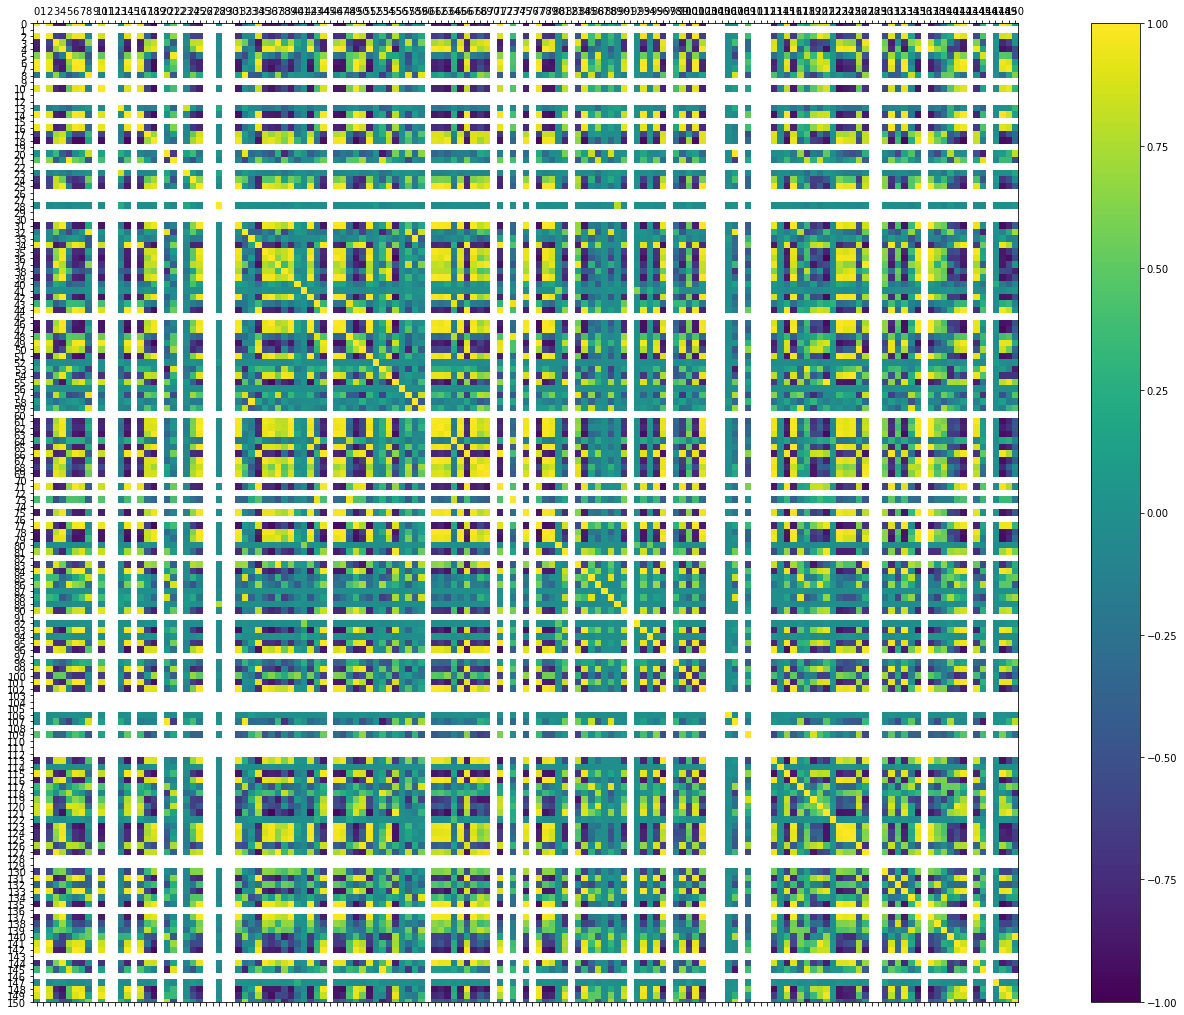

In [42]:
correlations = x_train.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,151,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
fig = plt.gcf()
fig.set_size_inches(26, 18)
fig.savefig('test2png.png', dpi=100)
# ax.set_xticklabels(names)
# ax.set_yticklabels(names)
plt.show()

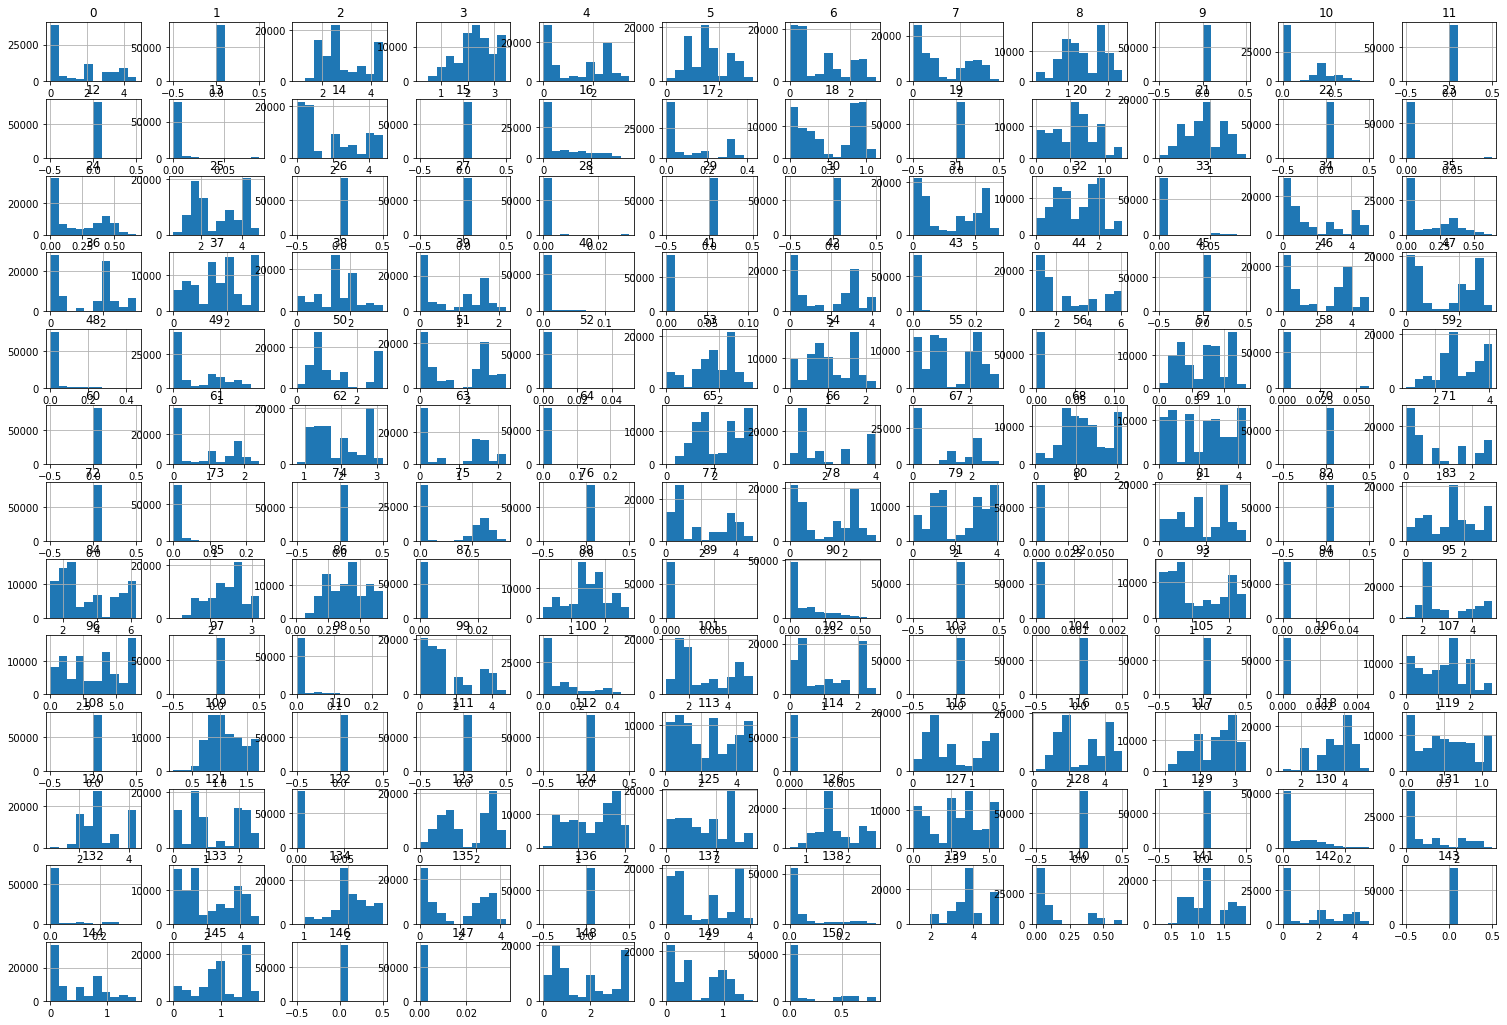

In [44]:
x_train.hist()
fig = plt.gcf()
fig.set_size_inches(26, 18)
fig.savefig('test2png.png', dpi=100)
# ax.set_xticklabels(names)
# ax.set_yticklabels(names)
plt.show()

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(x_train)
fig = plt.gcf()
fig.set_size_inches(26, 18)
fig.savefig('test2png.png', dpi=100)
# ax.set_xticklabels(names)
# ax.set_yticklabels(names)
plt.show()

In [36]:
attack_df_train=x_train['target']
attack_df_test=x_test['target']
# change the label column
new_attack_df_train=attack_df_train.replace({ 'Normal' : 0, 'Generic' : 1 ,'Exploits' : 2,'Fuzzers': 3,'DoS': 4,'Reconnaissance': 5,
                            'Analysis' : 6,'Backdoor' : 7,'Shellcode' : 8,'Worms' : 9})
new_attack_df_test=attack_df_test.replace({ 'Normal' : 0, 'Generic' : 1 ,'Exploits' : 2,'Fuzzers': 3,'DoS': 4,'Reconnaissance': 5,
                            'Analysis' : 6,'Backdoor' : 7,'Shellcode' : 8,'Worms' : 9})
# put the new label column back
x_train['target'] = new_attack_df_train
x_test['target'] = new_attack_df_test
print(x_train['target'].head())

KeyError: 'target'

In [28]:
normal_mask=x_train['target'] ==0
attack_mask=x_train['target'] !=0

# new_df_train.drop('attack_cat',axis=1,inplace=True)

x_normal=x_train[normal_mask]
x_attack=x_train[attack_mask]

normal_mask_test=x_test['target'] ==0
attack_mask_test=x_test['target'] !=0

# new_df_train.drop('attack_cat',axis=1,inplace=True)

normal_test=x_test[normal_mask_test]
attack_test=x_test[attack_mask_test]


print(x_normal.shape)
print(attack_test.head())

(37000, 152)
              0    1         2         3         4         5         6  \
47911  1.960441 -0.0  2.776419  2.160514  0.050507  0.859917  1.155958   
47912  1.997260 -0.0  2.734853  1.921154 -0.000000  0.925619  1.170454   
47913  1.934903 -0.0  2.744391  2.033281 -0.000000  0.868090  1.129034   
47914  2.040332 -0.0  2.854882  2.152881 -0.000000  0.906380  1.212169   
47915  1.901152 -0.0  2.676784  1.980191 -0.000000  0.859792  1.114164   

              7         8    9  ...       142  143  144       145  146  147  \
47911  1.824350  1.787447 -0.0  ...  1.944413 -0.0 -0.0  0.355336 -0.0 -0.0   
47912  1.897550  1.782919 -0.0  ...  1.973646 -0.0 -0.0  0.296630 -0.0 -0.0   
47913  1.919110  1.841020 -0.0  ...  1.889987 -0.0 -0.0  0.260061 -0.0 -0.0   
47914  1.976979  1.797827 -0.0  ...  2.005898 -0.0 -0.0  0.353943 -0.0 -0.0   
47915  1.828339  1.832324 -0.0  ...  1.867870 -0.0 -0.0  0.249740 -0.0 -0.0   

            148       149       150  target  
47911  2.047068  0.82

In [29]:
drop_Generic = [1]
drop_Exploits = [2]
drop_Fuzzers = [3]
drop_DoS = [4]
drop_Reconnaissance = [5]
drop_Analysis = [6]
drop_Backdoor = [7]
drop_Shellcode = [8]
drop_Worms = [9]

Generic_df=x_train[~x_train['target'].isin(drop_Generic)];
Exploits_df=x_train[~x_train['target'].isin(drop_Exploits)];
Fuzzers_df=x_train[~x_train['target'].isin(drop_Fuzzers)];
DoS_df=x_train[~x_train['target'].isin(drop_DoS)];
Reconnaissance_df=x_train[~x_train['target'].isin(drop_Reconnaissance)];
Analysis_df=x_train[~x_train['target'].isin(drop_Analysis)];
Backdoor_df=x_train[~x_train['target'].isin(drop_Backdoor)];
Shellcode_df=x_train[~x_train['target'].isin(drop_Shellcode)];
Worms_df=x_train[~x_train['target'].isin(drop_Worms)];

#test

Generic_df_test=x_test[~x_test['target'].isin(drop_Generic)];
Exploits_df_test=x_test[~x_test['target'].isin(drop_Exploits)];
Fuzzers_df_test=x_test[~x_test['target'].isin(drop_Fuzzers)];
DoS_df_test=x_test[~x_test['target'].isin(drop_DoS)];
Reconnaissance_df_test=x_test[~x_test['target'].isin(drop_Reconnaissance)];
Analysis_df_test=x_test[~x_test['target'].isin(drop_Analysis)];
Backdoor_df_test=x_test[~x_test['target'].isin(drop_Backdoor)];
Shellcode_df_test=x_test[~x_test['target'].isin(drop_Shellcode)];
Worms_df_test=x_test[~x_test['target'].isin(drop_Worms)];


print('Train:')

print('Dimensions of DoS:' ,Generic_df.shape)
print('Dimensions of Exploits:' ,Exploits_df.shape)
print('Dimensions of Fuzzers:' ,Fuzzers_df.shape)
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Reconnaissance:' ,Reconnaissance_df.shape)
print('Dimensions of Analysis:' ,Analysis_df.shape)
print('Dimensions of Backdoor:' ,Backdoor_df.shape)
print('Dimensions of Shellcode:' ,Shellcode_df.shape)
print('Dimensions of Worms:' ,Worms_df.shape)

print('Test:')
print('Dimensions of DoS:' ,Generic_df_test.shape)
print('Dimensions of Exploits:' ,Exploits_df_test.shape)
print('Dimensions of Fuzzers:' ,Fuzzers_df_test.shape)
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Reconnaissance:' ,Reconnaissance_df_test.shape)
print('Dimensions of Analysis:' ,Analysis_df_test.shape)
print('Dimensions of Backdoor:' ,Backdoor_df_test.shape)
print('Dimensions of Shellcode:' ,Shellcode_df_test.shape)
print('Dimensions of Worms:' ,Worms_df_test.shape)


Train:
Dimensions of DoS: (63461, 152)
Dimensions of Exploits: (71200, 152)
Dimensions of Fuzzers: (76270, 152)
Dimensions of DoS: (78243, 152)
Dimensions of Reconnaissance: (78836, 152)
Dimensions of Analysis: (81655, 152)
Dimensions of Backdoor: (81749, 152)
Dimensions of Shellcode: (81954, 152)
Dimensions of Worms: (82288, 152)
Test:
Dimensions of DoS: (135341, 152)
Dimensions of Exploits: (141948, 152)
Dimensions of Fuzzers: (157157, 152)
Dimensions of DoS: (163077, 152)
Dimensions of Reconnaissance: (164850, 152)
Dimensions of Analysis: (173341, 152)
Dimensions of Backdoor: (173595, 152)
Dimensions of Shellcode: (174208, 152)
Dimensions of Worms: (175211, 152)


In [30]:
X_Generic = Generic_df.drop('target',1)
Y_Generic = Generic_df.target

X_Exploits = Exploits_df.drop('target',1)
Y_Exploits = Exploits_df.target

X_Fuzzers = Fuzzers_df.drop('target',1)
Y_Fuzzers = Fuzzers_df.target

X_DoS = DoS_df.drop('target',1)
Y_DoS = DoS_df.target

X_Reconnaissance = Reconnaissance_df.drop('target',1)
Y_Reconnaissance = Reconnaissance_df.target

X_Analysis = Analysis_df.drop('target',1)
Y_Analysis = Analysis_df.target


X_Backdoor = Backdoor_df.drop('target',1)
Y_Backdoor = Backdoor_df.target


X_Shellcode = Shellcode_df.drop('target',1)
Y_Shellcode = Shellcode_df.target

X_Worms =Worms_df.drop('target',1)
Y_Worms =Worms_df.target

X_Generic_test = Generic_df_test.drop('target',1)
Y_Generic_test = Generic_df_test.target

X_Exploits_test = Exploits_df_test.drop('target',1)
Y_Exploits_test = Exploits_df_test.target

X_Fuzzers_test = Fuzzers_df_test.drop('target',1)
Y_Fuzzers_test = Fuzzers_df_test.target

X_DoS_test = DoS_df_test.drop('target',1)
Y_DoS_test = DoS_df_test.target

X_Reconnaissance_test = Reconnaissance_df_test.drop('target',1)
Y_Reconnaissance_test = Reconnaissance_df_test.target

X_Analysis_test = Analysis_df_test.drop('target',1)
Y_Analysis_test = Analysis_df_test.target


X_Backdoor_test = Backdoor_df_test.drop('target',1)
Y_Backdoor_test = Backdoor_df_test.target


X_Shellcode_test = Shellcode_df_test.drop('target',1)
Y_Shellcode_test = Shellcode_df_test.target

X_Worms_test =Worms_df_test.drop('target',1)
Y_Worms_test =Worms_df_test.target


In [31]:
X_normal=x_normal.drop('target',1)
Y_normal=x_normal.target

X_attack=x_attack.drop('target',1)
Y_attack=x_attack.target

X_normal_test=normal_test.drop('target',1)
Y_normal_test=normal_test.target

X_attack_test=attack_test.drop('target',1)
Y_attack_test=attack_test.target


In [32]:
def accuracy_report(classifier,X,y,num_cv):
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import precision_score
    from sklearn.model_selection import cross_val_predict

#   y_pred = cross_val_predict(classifier, X, y, cv=10)
    scores = cross_val_score(classifier, X,y, cv=num_cv)
    recall = cross_val_score(classifier, X, y, cv=num_cv, scoring='recall_weighted')
    precision = cross_val_score(classifier, X, y, cv=num_cv, scoring='precision_weighted')
    f1 = cross_val_score(classifier,X, y, scoring='f1_weighted', cv=num_cv)
    
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("Recall: %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))
    print("Precision: %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
    print("F1-Score: %0.2f (+/- %0.2f)" % (f1.mean(), f1.std() * 2))

In [33]:
from sklearn.ensemble import RandomForestClassifier

# rf_DoS = RandomForestClassifier(n_estimators=10)
# rf_DoS.fit(X_DoS, Y_DoS)

rf_Generic=RandomForestClassifier(n_estimators=10)
rf_Generic.fit(X_Generic,Y_Generic)

# rf_Exploits=RandomForestClassifier(n_estimators=10)
# rf_Exploits.fit(X_Exploits,Y_Exploits)

# rf_Fuzzers=RandomForestClassifier(n_estimators=10)
# rf_Fuzzers.fit(X_Fuzzers,Y_Fuzzers)

# rf_Analysis=RandomForestClassifier(n_estimators=10)
# rf_Analysis.fit(X_Analysis,Y_Analysis)

# rf_Backdoor=RandomForestClassifier(n_estimators=10)
# rf_Backdoor.fit(X_Backdoor,Y_Backdoor)

# rf_Shellcode=RandomForestClassifier(n_estimators=10)
# rf_Shellcode.fit(X_Shellcode,Y_Shellcode)

# rf_Worms=RandomForestClassifier(n_estimators=10)
# rf_Worms.fit(X_Worms,Y_Worms)

# rf_Reconnaissance=RandomForestClassifier(n_estimators=10)
# rf_Reconnaissance.fit(X_Reconnaissance,Y_Reconnaissance)

# rf_normal=RandomForestClassifier(n_estimators=10)
# rf_normal.fit(X_normal,Y_normal)

# rf_attack=RandomForestClassifier(n_estimators=10)
# rf_attack.fit(X_attack,Y_attack)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
# rf_DoS.predict(X_DoS_test)
rf_Generic.predict(X_Generic_test)
# rf_Exploits.predict(X_Exploits_test)
# rf_Fuzzers.predict(X_Fuzzers_test)
# rf_Analysis.predict(X_Analysis_test)
# rf_Backdoor.predict(X_Backdoor_test)
# rf_Shellcode.predict(X_Shellcode_test)
# rf_Worms.predict(X_Worms_test)
# rf_Reconnaissance.predict(X_Reconnaissance_test)
# rf_normal.predict(X_normal_test)
# rf_attack.predict(X_attack_test)

array([0, 2, 2, ..., 2, 2, 5], dtype=int64)

In [35]:
# rf_DoS.predict_proba(X_DoS_test)[0:10]
# rf_Generic.predict_proba(X_Generic_test)[0:10]

In [36]:
# Y_DoS_pred=rf_DoS.predict(X_DoS_test)
Y_Generic_pred=rf_Generic.predict(X_Generic_test)
# Y_Exploits_pred=rf_Exploits.predict(X_Exploits_test)
# Y_Fuzzers_pred=rf_Fuzzers.predict(X_Fuzzers_test)
# Y_Analysis_pred=rf_Analysis.predict(X_Analysis_test)
# Y_Backdoor_pred=rf_Backdoor.predict(X_Backdoor_test)
# Y_Shellcode_pred=rf_Shellcode.predict(X_Shellcode_test)
# Y_Worms_pred=rf_Worms.predict(X_Worms_test)
# Y_Reconnaissance_pred=rf_Reconnaissance.predict(X_Reconnaissance_test)
# Y_normal_pred=rf_normal.predict(X_normal_test)
# Y_attack_pred=rf_attack.predict(X_attack_test)
# Create confusion matrix
# pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

In [38]:
# DoS_accuracy=accuracy_report(rf_DoS,X_DoS_test,Y_DoS_test,10)

In [38]:
Exploits_accuracy=accuracy_report(rf_Exploits,X_Exploits_test,Y_Exploits_test,10)

Accuracy: 0.81 (+/- 0.15)
Recall: 0.81 (+/- 0.15)
Precision: 0.82 (+/- 0.07)
F1-Score: 0.80 (+/- 0.13)


In [39]:
Shellcode_accuracy=accuracy_report(rf_Shellcode,X_Shellcode_test,Y_Shellcode_test,10)

Accuracy: 0.74 (+/- 0.13)
Recall: 0.74 (+/- 0.12)
Precision: 0.75 (+/- 0.06)
F1-Score: 0.73 (+/- 0.11)


In [39]:
Generic_accuracy=accuracy_report(rf_Generic,X_Generic_test,Y_Generic_test,10)

Accuracy: 0.67 (+/- 0.16)
Recall: 0.67 (+/- 0.16)
Precision: 0.68 (+/- 0.07)
F1-Score: 0.66 (+/- 0.13)


In [ ]:
Fuzzers_accuracy=accuracy_report(rf_Fuzzers,X_Fuzzers_test,Y_Fuzzers_test,10)

In [ ]:
Analysis_accuracy=accuracy_report(rf_Analysis,X_Analysis_test,Y_Analysis_test,10)

In [ ]:
Backdoor_accuracy=accuracy_report(rf_Backdoor,X_Backdoor_test,Y_Backdoor_test,10)

In [ ]:
Shellcode_accuracy=accuracy_report(rf_Shellcode,X_Shellcode_test,Y_Shellcode_test,10)

In [ ]:
Worms_accuracy=accuracy_report(rf_Worms,X_Worms_test,Y_Worms_test,10)

In [ ]:
Reconnaissance_accuracy=accuracy_report(rf_Reconnaissance,X_Reconnaissance_test,Y_Reconnaissance_test,10)

In [ ]:
Normal_accuracy=accuracy_report(rf_normal,X_normal_test,Y_normal_test,10)

In [ ]:
Attack_accuracy=accuracy_report(rf_attack,X_attack_test,Y_attack_test,10)